# [ Going Deeper(CV) ] 10. ÎÇòÎ•º Ï∞æÏïÑÏ§ò - Class Activation Map ÎßåÎì§Í∏∞

‚úÖÏ†ïÏùò

---
### - üìñÎ™©Ï∞®
* ‚úîÔ∏è10-9. ÌîÑÎ°úÏ†ùÌä∏: CAMÏùÑ ÎßåÎì§Í≥† ÌèâÍ∞ÄÌï¥ Î≥¥Ïûê
* ‚úîÔ∏èÌöåÍ≥† Î∞è Í≤∞Î°†
* ‚úîÔ∏èReference(Ï∞∏Í≥†ÏûêÎ£å)

<br>



## ‚úîÔ∏è10-9. ÌîÑÎ°úÏ†ùÌä∏: CAMÏùÑ ÎßåÎì§Í≥† ÌèâÍ∞ÄÌï¥ Î≥¥Ïûê
---
### ÎùºÏù¥Î∏åÎü¨Î¶¨ Î≤ÑÏ†Ñ ÌôïÏù∏ÌïòÍ∏∞


https://github.com/nidolight/AIffel_GoingDeeper/blob/main/%5BG-06%5DCAM_gradCAM_IoU/%5BG-06%5DCAM_gradCAM_IoU.ipynb

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Î™®Îìà Î°úÎìú

import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [ ]:
# ÏµúÏ¥à ÏàòÌñâÏãúÏóêÎäî Îã§Ïö¥Î°úÎìúÍ∞Ä ÏßÑÌñâÎê©ÎãàÎã§. Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏúºÎãà Ïú†ÏùòÌï¥ Ï£ºÏÑ∏Ïöî.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLRU6XO/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLRU6XO/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


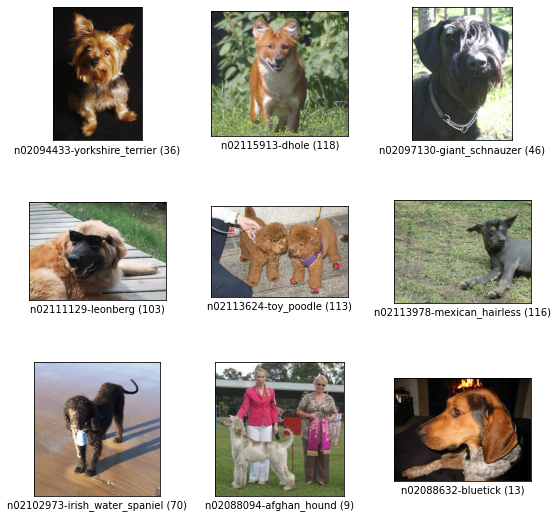

In [ ]:
ex_train = tfds.show_examples(ds_train, ds_info)

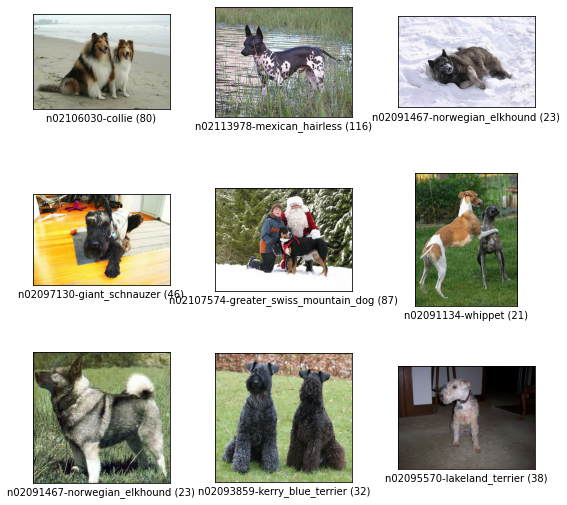

In [ ]:
ex_test = tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï†ÑÏ≤òÎ¶¨ÏôÄ Î∞∞ÏπòÏ≤òÎ¶¨Î•º Ï†ÅÏö©Ìï©ÎãàÎã§. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# Íµ¨ÏÑ±Îêú Î∞∞ÏπòÏùò Î™®ÏñëÏùÑ ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


<br>


-----
### CAM Íµ¨ÌòÑÌïòÍ∏∞

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet Î∂ÑÎ•òÍ∏∞  fully connected layer Ï†úÍ±∞
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAPÎ•º Ï†ÅÏö©  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 180s 215ms/step - loss: 2.2155 - accuracy: 0.4467 - val_loss: 3.4140 - val_accuracy: 0.2056
Epoch 2/15
750/750 [==============================] - 161s 214ms/step - loss: 0.6859 - accuracy: 0.8156 - val_loss: 1.0720 - val_accuracy: 0.6776
Epoch 3/15
750/750 [==============================] - 160s 214ms/step - loss: 0.1817 - accuracy: 0.9657 - val_loss: 0.9204 - val_accuracy: 0.7368
Epoch 4/15
750/750 [==============================] - 160s 214ms/step - loss: 0.0472 - accuracy: 0.9978 - val_loss: 0.8956 - val_accuracy: 0.7396
Epoch 5/15
750/750 [==============================] - 160s 214ms/step - loss: 0.0202 - accuracy: 0.9998 - val_loss: 0.9027 - val_accuracy: 0.7424
Epoch 6/15
750/750 [==============================] - 160s 213ms/step - loss: 0.0129 - accuracy: 0.9999 - val_loss: 0.9296 - val_accuracy: 0.7389
Epoch 7/15
750/750 [==============================] - 160s 214ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9448 - val_accura

In [ ]:
# Í∞ÄÏ§ëÏπò Ï†ÄÏû•ÌïòÍ∏∞
cam_model_path = 'cam_model1.h5'
cam_model.save(cam_model_path)

In [ ]:
# Class Activation Map
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


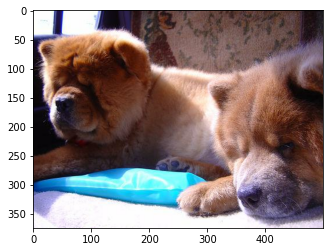

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
cam_model_path = 'cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # ÌïôÏäµÌïú Î™®Îç∏ÏóêÏÑú ÏõêÌïòÎäî LayerÏùò outputÏùÑ ÏñªÍ∏∞ ÏúÑÌï¥ÏÑú Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùòÌï¥Ï§çÎãàÎã§.
    # model.layers[-3].outputÏóêÏÑúÎäî Ïö∞Î¶¨Í∞Ä ÌïÑÏöîÎ°ú ÌïòÎäî GAP Ïù¥Ï†Ñ Convolution layerÏùò outputÏùÑ ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #ÎßàÏßÄÎßâ Î™®Îç∏Ïùò weight activationÏùÑ Í∞ÄÏ†∏ÏòµÎãàÎã§.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f Î•º ÌÜµÌï¥ classÎ≥Ñ activation mapÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation scoreÎ•º normalizeÌï©ÎãàÎã§.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # ÏõêÎûò Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î°ú resizeÌï©ÎãàÎã§.
    return cam_image

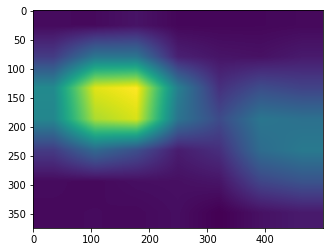

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

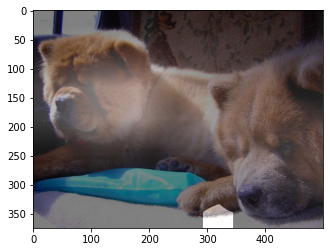

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<br>


-----
### Grad-CAM Íµ¨ÌòÑÌïòÍ∏∞

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad camÏóêÏÑúÎèÑ camÍ≥º Í∞ôÏù¥ ÌäπÏ†ï Î†àÏù¥Ïñ¥Ïùò outputÏùÑ ÌïÑÏöîÎ°ú ÌïòÎØÄÎ°ú Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùòÌï©ÎãàÎã§.
    # Ïù¥Îïå ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Í∞Ä Îã§Î•º Ïàò ÏûàÏúºÎãà Ìï¥Îãπ Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏúºÎ°ú Ï∞æÏùÄ ÌõÑ outputÏúºÎ°ú Ï∂îÍ∞ÄÌï©ÎãàÎã§.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # GradientÎ•º ÏñªÍ∏∞ ÏúÑÌï¥ tapeÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # ÏõêÌïòÎäî class(Ïó¨Í∏∞ÏÑúÎäî Ï†ïÎãµÏúºÎ°ú ÌôúÏö©) ÏòàÏ∏°Í∞íÏùÑ ÏñªÏäµÎãàÎã§.
        output = conv_output[0] # ÏõêÌïòÎäî layerÏùò outputÏùÑ ÏñªÏäµÎãàÎã§.
        grad_val = tape.gradient(loss, conv_output)[0] # ÏòàÏ∏°Í∞íÏóê Îî∞Î•∏ LayerÏùò gradientÎ•º ÏñªÏäµÎãàÎã§.

    weights = np.mean(grad_val, axis=(0, 1)) # gradientÏùò GAPÏúºÎ°ú classÎ≥Ñ weightÎ•º Íµ¨Ìï©ÎãàÎã§.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # Í∞Å classÎ≥Ñ weightÏôÄ Ìï¥Îãπ layerÏùò outputÏùÑ Í≥±Ìï¥ class activation mapÏùÑ ÏñªÏäµÎãàÎã§.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [ ]:
def visualize_result(blockname):
  grad_cam_image = generate_grad_cam(cam_model, blockname, item)

  origin_image = item['image'].astype(np.uint8)
  grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
  blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

  plt.figure(figsize=(15,30))
  plt.subplot(1,2,1)
  plt.title('CAM image')
  plt.imshow(grad_cam_image)

  plt.subplot(1,2,2)
  plt.title('visualize CAM on image')
  plt.imshow(blended_image)
  plt.show()

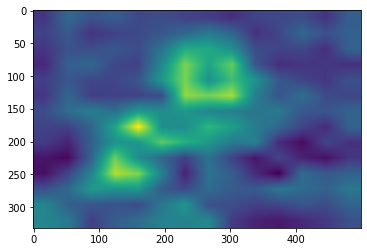

In [ ]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

<br>


-----
### Î∞îÏö¥Îî© Î∞ïÏä§ Íµ¨ÌïòÍ∏∞

67


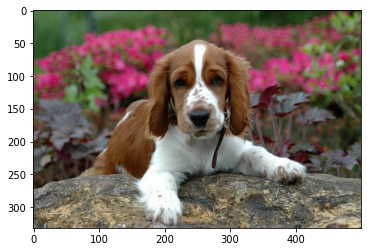

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

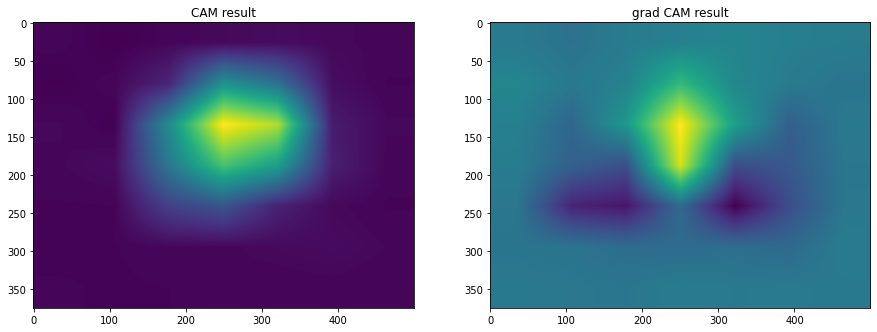

In [ ]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(cam_image)
plt.title('CAM result')

plt.subplot(1,2,2)
plt.imshow(grad_cam_image)
plt.title('grad CAM result')

plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [ ]:
rect1 = get_bbox(cam_image)
rect2 = get_bbox(grad_cam_image)
rect1

array([[115, 336],
       [ 51,  99],
       [397,   4],
       [462, 242]])

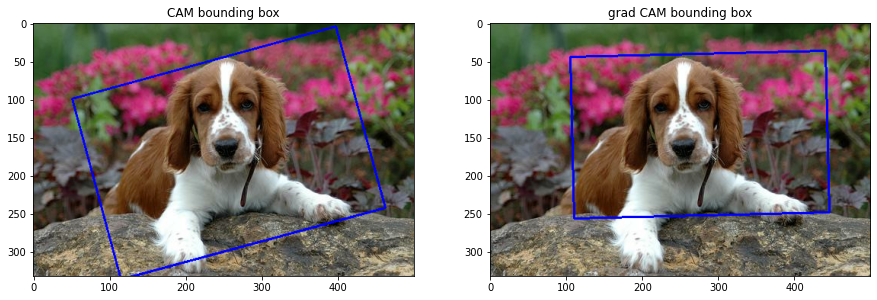

In [ ]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.title('CAM bounding box')

plt.subplot(1,2,2)
plt.imshow(image2)
plt.title('grad CAM bounding box')
plt.show()

<br>


-----
### IoU Íµ¨ÌïòÍ∏∞

In [ ]:
# rectÏùò Ï¢åÌëúÎäî (x, y) ÌòïÌÉúÎ°ú, bboxÎäî (y_min, x_min, y_max, x_max)Ïùò normalized ÌòïÌÉúÎ°ú Ï£ºÏñ¥ÏßëÎãàÎã§. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding boxÏùò y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding boxÏùò x_min
        rect[:,1].max()/float(image.shape[0]), #bounding boxÏùò y_max
        rect[:,0].max()/float(image.shape[1]) #bounding boxÏùò x_max
    ]
    return bbox

In [ ]:
pred_bbox1 = rect_to_minmax(rect1, item['image'])
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox1

[0.08266666666666667, 0.224, 0.76, 0.84]

In [ ]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [ ]:
def get_iou(boxA, boxB):  # iou Í≥ÑÏÇ∞
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
# CAM bounding box IoU
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.6129092826939376

In [ ]:
# grad CAM bounding box IoU
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.7766520298823889

## ‚úîÔ∏èÌöåÍ≥† Î∞è Í≤∞Î°†
---

#### ‚ñ∂Ô∏è Ïù¥Î≤à ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑú Ïñ¥Î†§Ïõ†Îçò Ï†ê

camÏùò Í∏∞Î≥∏Ï†ÅÏù∏ Íµ¨Ï°∞ÏóêÏÑú Í∏∞Ïö∏Í∏∞Î•º Ïù¥Ïö©ÌïòÎäî Í≥ºÏ†ïÏùÑ grad-camÏù¥ÎùºÎäî Í≤É ÍπåÏßÄÎäî ÏïåÍ≤†ÎäîÎç∞, Ïù¥Í≤å Íµ¨Ï≤¥Ï†ÅÏúºÎ°ú Ïñ¥ÎñªÍ≤å ÏßÑÌñâÎêòÎäîÏßÄ ÏïÑÏßÅ Î∂àÎ∂ÑÎ™ÖÌïòÎã§. Ïò§ÌûàÎ†§ Global Average PoolingÏóêÏÑúÏùò Í≥ºÏ†ïÏù¥ Ìõ®Ïî¨ ÏôÄÎãøÏïòÎäîÎç∞, Ïù¥ Í≥ºÏ†ïÏóêÏÑú Ï¢Ä Îçî ÏïàÏ™ΩÏùò Í∏∞Ïö∏Í∏∞Î•º Ï†ÅÍ∑πÏ†ÅÏúºÎ°ú Í∞ÄÏö©Ìïú Í≤å grad-camÏù¥ Ïôú Îçî Ìö®Ïú®Ïù¥ Ï¢ãÏùÄÏßÄ Îã§Ïãú ÏÉùÍ∞ÅÌï¥Î≥¥Í≤å ÎßåÎì§ÏóàÎã§.

<br>

#### ‚ñ∂Ô∏è ÌîÑÎ°úÏ†ùÌä∏Î•º ÏßÑÌñâÌïòÎ©¥ÏÑú ÏïåÏïÑÎÇ∏ Ï†ê ÌòπÏùÄ ÏïÑÏßÅ Î™®Ìò∏Ìïú Ï†ê

Îã®ÏàúÌûà Î™®Îç∏Ïùò Í≥ºÏ†ï ÏûêÏ≤¥Î•º ÏãúÍ∞ÅÌôîÌïúÎã§Îäî ÏûêÏ≤¥ÎèÑ Ïã†Í∏∞ÌñàÎäîÎç∞, ÌûàÌä∏ÎßµÍ∞ôÏùÄ Íµ¨Ï°∞Î•º ÌôúÏö©Ìï¥ÏÑú Î™®Îç∏Ïù¥ Ïñ¥Îîú Ïù¥Ïö©Ìï¥ÏÑú ÎùºÎ≤®ÎßÅÏùÑ Íµ¨Î∂ÑÌïòÎäîÏßÄÎ•º ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú Î≥º Ïàò ÏûàÎã§Îäî Îç∞ÏÑú ÏñºÎßàÎÇò ÎßéÏùÄ ÏÇ¨ÎûåÎì§Ïù¥ Îî•Îü¨ÎãùÏùò Í≥ºÏ†ïÏùÑ Î≥¥Í∏∞ ÏúÑÌï¥ ÎÖ∏Î†•ÌñàÎäîÏßÄÍ∞Ä ÎäêÍª¥Ï°åÎã§. ÌïòÏßÄÎßå Ïù¥ Í≥ºÏ†ï Ï°∞Ï∞®ÎèÑ ÏÇ¨ÎûåÏù¥ Ïù¥Ìï¥Ìï† Ïàò ÏûàÎäî Íµ¨Ï°∞Î°ú Î∞îÍæº Í≤É ÎøêÏù¥ÎùºÎäî ÏÉùÍ∞ÅÏùÑ Ïô†ÏßÄ ÏßÄÏö∏ Ïàò ÏóÜÏóàÎã§.

<br>


#### ‚ñ∂Ô∏è Î£®Î∏åÎ¶≠ ÌèâÍ∞Ä ÏßÄÌëúÎ•º ÎßûÏ∂îÍ∏∞ ÏúÑÌï¥ ÏãúÎèÑÌïú Í≤ÉÎì§

Ïù¥Î≤à ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑú Î£®Î∏åÎ¶≠Ïùò Í∏∞Ï§ÄÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏïòÎã§.

|       |                                    **< ÌèâÍ∞ÄÎ¨∏Ìï≠ >**                                   |                                                              **< ÏÉÅÏÑ∏Í∏∞Ï§Ä >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | CAMÏùÑ ÏñªÍ∏∞ ÏúÑÌïú Í∏∞Î≥∏Î™®Îç∏Ïùò Íµ¨ÏÑ±Í≥º ÌïôÏäµÏù¥ Ï†ïÏÉÅ ÏßÑÌñâÎêòÏóàÎäîÍ∞Ä?                                 | ResNet50 + GAP + DenseLayer Í≤∞Ìï©Îêú CAM Î™®Îç∏Ïùò ÌïôÏäµÍ≥ºÏ†ïÏù¥ ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÏàòÎ†¥ÌïòÏòÄÎã§.<br>                                                        |
| **2** | Î∂ÑÎ•òÍ∑ºÍ±∞Î•º ÏÑ§Î™Ö Í∞ÄÎä•Ìïú Class activation mapÏùÑ ÏñªÏùÑ Ïàò ÏûàÎäîÍ∞Ä? | CAM Î∞©ÏãùÍ≥º Grad-CAM Î∞©ÏãùÏùò class activation mapÏù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏñªÏñ¥ÏßÄÎ©∞, ÏãúÍ∞ÅÌôîÌïòÏòÄÏùÑ Îïå Ìï¥Îãπ objectÏùò Ï£ºÏöî ÌäπÏßï ÏúÑÏπòÎ•º Ïûò Î∞òÏòÅÌïúÎã§.                               |
| **3** | Ïù∏ÏãùÍ≤∞Í≥ºÏùò ÏãúÍ∞ÅÌôî Î∞è ÏÑ±Îä• Î∂ÑÏÑùÏùÑ Ï†ÅÏ†àÌûà ÏàòÌñâÌïòÏòÄÎäîÍ∞Ä?                                    | CAMÍ≥º Grad-CAM Í∞ÅÍ∞ÅÏóê ÎåÄÌï¥ ÏõêÎ≥∏Ïù¥ÎØ∏ÏßÄÌï©ÏÑ±, Î∞îÏö¥Îî©Î∞ïÏä§, IoU Í≥ÑÏÇ∞ Í≥ºÏ†ïÏùÑ ÌÜµÌï¥ CAMÍ≥º Grad-CAMÏùò object localization ÏÑ±Îä•Ïù¥ ÎπÑÍµêÎ∂ÑÏÑùÎêòÏóàÎã§. |

grad-CAMÏùò ÏÑ±Îä•Ïù¥ ÎØ∏Î¨òÌïòÍ≤å Îçî Ï¢ãÎã§Îäî Ï†êÏóêÏÑú Ï†úÎåÄÎ°ú ÎèåÏïÑÍ∞Ñ Í≤å ÎßûÎäîÏßÄÍπåÏßÄ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÎäîÎç∞, IoUÎ•º Ïù¥Ïö©Ìï¥ÏÑú Í≤∞Í≥ºÎ•º ÎèÑÏ∂úÌïòÎäî Í≥ºÏ†ïÏù¥ Ï¢Ä ÎßâÌòîÏóàÎã§. Ïò§ÌûàÎ†§ camÏùò ÏÑ±Îä•Ïù¥ Ï¢ãÏïòÎçò Í≤ΩÏö∞ÎèÑ ÏûàÏóàÎäîÎç∞ ÏÇ¨ÏßÑÏùÑ Î∞îÍæ∏ÎãàÍπå Ï†úÎåÄÎ°ú ÎèåÏïÑÏôîÎçòÍ≤å Îç∞Ïù¥ÌÑ∞ ÎïåÎ¨∏Ïù∏Í∞Ä Í≥†ÎØºÌïòÍ≤å ÎßåÎì§ÏóàÎã§. Ïñ¥Ï®åÍ±∞ÎÇò ÍπÉÌóàÎ∏åÏùò Ïö¥Ï¥ù ÎçïÎ∂ÑÏóê Ïñ¥Î†µÏßÄ ÏïäÍ≤å ÎßàÎ¨¥Î¶¨ ÏßÄÏùÑ Ïàò ÏûàÏóàÎã§.


<br>

#### ‚ñ∂Ô∏è ÏûêÍ∏∞ Îã§Ïßê

ÏõêÌôúÌïòÍ≤å ÎèåÏïÑÍ∞ÄÎäî ÏΩîÎìúÎ•º ÎèÑÏõÄÏóÜÏù¥ Ïß†Îã§ÎäîÍ±¥ ÏâΩÏßÄ ÏïäÎã§. ÎòëÍ∞ôÏùÄ ÏΩîÎìúÎ•º Ï†úÎåÄÎ°ú Îêú ÌÉÄÏù¥Î∞çÏóê Ïò®Ï†ÑÌûà ÏÉùÍ∞ÅÌïòÎ©¥ÏÑú Ïò§Î•òÏóÜÏù¥ Íµ¨ÌòÑÌï† Ïàò ÏûàÏùÑÍπåÎ•º Î¨ªÎäîÎã§Î©¥ ÏïÑÏßÅÎèÑ ÏûêÏã†Ïù¥ ÏóÜÎã§........

<br>

## ‚úîÔ∏èReference(Ï∞∏Í≥†ÏûêÎ£å)
---
* https://github.com/Ssuwani/aiffel/blob/6c5b849fb55407e8fb08706c6fb619c12827f9ed/goingdeeper/G6/cam-vs-gradcam.ipynb
* https://github.com/software1398/aiffel/blob/09cd8db8e9914fc0bf4991871f860b077dbdde13/CV/CV10%20-%20Class%20Activation%20Map.ipynb
* https://tyami.github.io/deep%20learning/CNN-visualization-Grad-CAM/
* https://wikidocs.net/135874
* https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp
* https://jsideas.net/grad_cam/